### ***Problem Statement*** - The aim of this project is to develop an advanced Response-Augmented Generation (RAG) system that leverages multiple data sources such as arXiv, Wikipedia, and other reputable repositories. This system will integrate cutting-edge language modeling techniques to enhance the generation of informative and contextually relevant responses.

### **System Architecture**

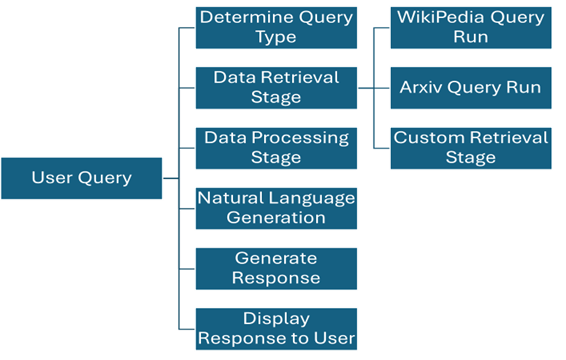

**Installing the necessary libraries**




In [1]:
!pip install arxiv
!pip install -q langchain_experimental==0.0.49 langchain
!pip install langchain-community --trusted-host mirrors.cloud.tencent.com
!pip install -q wikipedia
!pip install -q faiss-gpu
!pip install -q python-dotenv

# Installing the langchain_openai Python package
!pip install -q  langchain_openai

# Installing the langchainhub Python package
!pip install langchainhub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=f6b5dae4973c7b01b36394c9317cae9f04caf8b0e88a25351ac15a0bdb41d9df
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.7/165.7 kB 4.1 MB/s et

**Importing the necessary libraries**

In [3]:
# Import the getpass module to securely get a password input without echoing it back.
import getpass

# Import the os module to interact with the operating system.
import os

# Import the getpass function directly for easier access to password input functionality.
from getpass import getpass

# Importing relevant classes/libraries for performing queries and interactions with Wikipedia data
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

# Importing various classes from the langchain_community library, designed to handle specific functions related to document processing and vector storage
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Importing create_retriever_tool function, designed to create a retriever tool
from langchain.tools.retriever import create_retriever_tool

## Importing Arxiv Tools
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun

# Import the function to load environment variables from a '.env' file.
from dotenv import load_dotenv

# Import the OpenAI model class from the langchain_community library for language model interactions.
from langchain_community.llms import OpenAI

# Import the ChatOpenAI class from the langchain_community library for handling chat-based models.
from langchain_community.chat_models import ChatOpenAI

# Import the 'hub' module from the 'langchain' library to access pre-built models and functionalities.
from langchain import hub

# Importing create_openai_tools_agent from the langchain.agents
from langchain.agents import create_openai_tools_agent

## Importing AgentExecuter from langchain.agents
from langchain.agents import AgentExecutor

**Setting the API key Environment**

In [4]:
# Setting the environment to securely prompts the user for the OpenAI API key

os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key: ")

OpenAI API Key: ··········


**Creating Tool 1**

In [5]:
# Initialising a WikipediaAPIWrapper object and passing the configured API wrapper to handle Wikipedia queries.
api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [6]:
# Accessing the name attribute of the wiki object
wiki.name

'wikipedia'

In [7]:
# Document Loading and Processing
loader=WebBaseLoader("https://docs.smith.langchain.com/")
docs=loader.load()
documents=RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200).split_documents(docs)

# Vector Database Setup
vectordb=FAISS.from_documents(documents,OpenAIEmbeddings())

# Retriever
retriever=vectordb.as_retriever()
retriever


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7b5803397310>)

**Creating Tool 2**

In [8]:
# retriever_tool is now getting ready to be used for relevant searches about "LangSmith", leveraging the pre-processed and embedded document data.
retriever_tool=create_retriever_tool(retriever,"langsmith_search",
                      "Search for information about LangSmith. For any questions about LangSmith, you must use this tool!")

In [9]:
# retriever_tool.name accesses the name attribute of the retriever_tool object
retriever_tool.name

'langsmith_search'

**Creating Tool 3**

In [10]:
# Initialising an ArxivAPIWrapper object and an ArxivQueryRun object to interact with the arXiv API for querying scientific papers
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)
arxiv.name

'arxiv'

**Combing all the tools**

In [11]:
# Combing all the three tools created in above steps such as: wiki, arxiv, and retriever_tool
tools=[wiki,arxiv,retriever_tool]

In [12]:
tools

[WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.10/dist-packages/wikipedia/__init__.py'>, top_k_results=1, lang='en', load_all_available_meta=False, doc_content_chars_max=200)),
 ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=1, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=200, arxiv_result=<class 'arxiv.Result'>)),
 Tool(name='langsmith_search', description='Search for information about LangSmith. For any questions about LangSmith, you must use this tool!', args_schema=<class 'langchain_core.tools.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x7b581c489870>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_com

In [13]:
# Load environment variables from a .env file into the system's environment.
load_dotenv()

# Initialize a ChatGPT model with deterministic responses using the gpt-3.5-turbo-0125 model configuration.
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [14]:
# Retrieving a prompt template
prompt = hub.pull("hwchase17/openai-functions-agent")

# Accessing the messages attribute of the object stored in the prompt variable
prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant')),
 MessagesPlaceholder(variable_name='chat_history', optional=True),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}')),
 MessagesPlaceholder(variable_name='agent_scratchpad')]

In [15]:
# Initialising a new agent using the create_openai_tools_agent function
agent=create_openai_tools_agent(llm,tools,prompt)

In [16]:
# Creating an AgentExecutor with detailed logging, using the specified agent and tools.
agent_executor=AgentExecutor(agent=agent,tools=tools,verbose=True)
agent_executor

AgentExecutor(verbose=True, agent=RunnableMultiActionAgent(runnable=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_to_openai_tool_messages(x['intermediate_steps']))
})
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'openai-functions-agent', 'lc_hub_commit_hash': 'a165

### **Generating Responses Using AgentExecutor**

**Response 1**

In [17]:
agent_executor.invoke({"input":"Tell me about Langsmith"})



> Entering new AgentExecutor chain...

Invoking: `langsmith_search` with `{'query': 'Langsmith'}`


Get started with LangSmith | ü¶úÔ∏èüõ†Ô∏è LangSmith

Skip to main contentGo to API DocsSearchGo to AppQuick startTutorialsHow-to guidesConceptsReferencePricingSelf-hostingLangGraph CloudQuick startOn this pageGet started with LangSmithLangSmith is a platform for building production-grade LLM applications. It allows you to closely monitor and evaluate your application, so you can ship quickly and with confidence. Use of LangChain is not necessary - LangSmith works on its own!1. Install LangSmith‚ÄãPythonTypeScriptpip install -U langsmithyarn add langchain langsmith2. Create an API key‚ÄãTo create an API key head to the Settings page. Then click Create API Key.3. Set up your environment‚ÄãShellexport LANGCHAIN_TRACING_V2=trueexport LANGCHAIN_API_KEY=<your-api-key># The below examples use the OpenAI API, though it's not necessary in generalexport OPENAI_API_KEY=<your-openai-api-key>4. L

{'input': 'Tell me about Langsmith',
 'output': 'LangSmith is a platform for building production-grade LLM (Large Language Model) applications. It allows you to closely monitor and evaluate your application, enabling you to ship quickly and with confidence. LangSmith works independently and does not require the use of LangChain.\n\nTo get started with LangSmith, you can follow these steps:\n1. Install LangSmith using pip install -U langsmith for Python or yarn add langchain langsmith for TypeScript.\n2. Create an API key by heading to the Settings page and clicking on Create API Key.\n3. Set up your environment by exporting necessary variables like LANGCHAIN_TRACING_V2 and LANGCHAIN_API_KEY.\n4. Log your first trace by using the provided code examples to log traces to LangSmith.\n\nLangSmith provides various features such as creating datasets, examples, and evaluators to evaluate your models. You can learn more about evaluation in the how-to guides available on the LangSmith platform.\

**Response 2**

In [18]:
agent_executor.invoke({"input":"What are the key features and benefits of using langsmith for language learning?"})



> Entering new AgentExecutor chain...

Invoking: `langsmith_search` with `{'query': 'key features and benefits of using LangSmith for language learning'}`


Get started with LangSmith | ü¶úÔ∏èüõ†Ô∏è LangSmith

Skip to main contentGo to API DocsSearchGo to AppQuick startTutorialsHow-to guidesConceptsReferencePricingSelf-hostingLangGraph CloudQuick startOn this pageGet started with LangSmithLangSmith is a platform for building production-grade LLM applications. It allows you to closely monitor and evaluate your application, so you can ship quickly and with confidence. Use of LangChain is not necessary - LangSmith works on its own!1. Install LangSmith‚ÄãPythonTypeScriptpip install -U langsmithyarn add langchain langsmith2. Create an API key‚ÄãTo create an API key head to the Settings page. Then click Create API Key.3. Set up your environment‚ÄãShellexport LANGCHAIN_TRACING_V2=trueexport LANGCHAIN_API_KEY=<your-api-key># The below examples use the OpenAI API, though it's not necessary 

{'input': 'What are the key features and benefits of using langsmith for language learning?',
 'output': 'LangSmith is a platform for building production-grade LLM applications that offers the following key features and benefits for language learning:\n\n1. Close Monitoring and Evaluation: LangSmith allows you to closely monitor and evaluate your language learning application, ensuring that you can ship quickly and with confidence.\n\n2. Standalone Functionality: LangSmith works on its own without the need for LangChain, making it a convenient and efficient tool for language learning.\n\n3. Easy Installation: You can install LangSmith easily using Python or TypeScript with simple commands like `pip install -U langsmith` or `yarn add langchain langsmith`.\n\n4. API Key Creation: LangSmith provides a simple process for creating an API key through the Settings page, enabling secure access to the platform.\n\n5. Environment Setup: You can set up your environment by exporting necessary vari

**Response 3**

In [19]:
agent_executor.invoke({"input":"Tell me about Machine Learning"})



> Entering new AgentExecutor chain...

Invoking: `wikipedia` with `Machine Learning`


Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and genMachine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generate insights or predictions. It involves creating models that can automatically learn and improve from experience without being explicitly programmed. Machine learning algorithms are used in various applications such as image recognition, natural language processing, and recommendation systems.

> Finished chain.


{'input': 'Tell me about Machine Learning',
 'output': 'Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generate insights or predictions. It involves creating models that can automatically learn and improve from experience without being explicitly programmed. Machine learning algorithms are used in various applications such as image recognition, natural language processing, and recommendation systems.'}

**Response 4**

In [20]:
agent_executor.invoke({"input":"What's the paper 1605.08386 about?"})



> Entering new AgentExecutor chain...

Invoking: `arxiv` with `{'query': '1605.08386'}`


Published: 2016-05-26
Title: Heat-bath random walks with Markov bases
Authors: Caprice Stanley, Tobias Windisch
Summary: Graphs on lattice points are studied whose edges come from a finite set of
alloThe paper with the identifier 1605.08386 is titled "Heat-bath random walks with Markov bases" by Caprice Stanley and Tobias Windisch. It discusses the study of graphs on lattice points where the edges are derived from a finite set of allocations.

> Finished chain.


{'input': "What's the paper 1605.08386 about?",
 'output': 'The paper with the identifier 1605.08386 is titled "Heat-bath random walks with Markov bases" by Caprice Stanley and Tobias Windisch. It discusses the study of graphs on lattice points where the edges are derived from a finite set of allocations.'}